In [2]:
def H(ra, dec, z):

    ra  = np.array(ra,  dtype=np.float32) 
    dec = np.array(dec, dtype=np.float32) 
    z   = np.array(z,   dtype=np.float32) 

    r = np.float32(cosmo.comoving_distance(z).value)
    x = r*np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
    y = r*np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
    z = r*np.sin(np.deg2rad(dec))
    return x, y, z

import pandas as pd
import numpy as np
import treecorr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
######################
minsep = 10.      # Min theta
maxsep = 80.      # Max theta
nbins = 10        # Bins in theta


# Read Gxs
zmin, zmax = 0.01, 0.15
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]

# Filament Gxs
filgxs = cat_sdss[cat_sdss['dist_fil']<=3.]

# Non-filament Gxs
nonfilgxs = cat_sdss[cat_sdss['dist_fil']>8.25]

# Read Randoms & Build Catalog
cat_random = pd.read_csv('../data/random_sample_healpy_128_561286.csv')
cat_random["x"], cat_random["y"], cat_random["z"] = H(cat_random["ra"], cat_random["dec"], cat_random["red"])




In [1]:
import os

# Compilar
exe = 'force_brute'
comando = 'gcc -c -g -fPIC -lm %s.c -o %s.o' % (exe, exe)
os.system(comando)

# Ejecutar
comando = 'gcc -g -shared -lm %s.o -o %s.so' % (exe, exe)
os.system(comando)


#(int ngal1, int ngal2, int nbins, double min_sep, double max_sep, double min_pi, double max_pi,
#                           double* x1, double* y1, double* z1, double* x2, double* y2, double* z2,
#                           , double* true_npairs)
import numpy.ctypeslib as npct
import ctypes

#Cargar libreria
libcd = npct.load_library('%s.so' % exe, '.')

array_1d_double = npct.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
libcd.calcular_correlacion.argtypes = [\
    npct.ctypes.c_int,\
    npct.ctypes.c_int,\
    npct.ctypes.c_int,\
    npct.ctypes.c_double,\
    npct.ctypes.c_double,\
    npct.ctypes.c_double,\
    npct.ctypes.c_double,\
    array_1d_double,\
    array_1d_double,\
    array_1d_double,\
    array_1d_double,\
    array_1d_double,\
    array_1d_double,\
    array_1d_double]

ngal1 = len(cat_sdss)
ngal2 = len(cat_random)
nbins = 10
rmin_perp = ctypes.c_double(10.0)
rmax_perp = ctypes.c_double(50.0)
rmin_pll = ctypes.c_double(10.0)
rmax_pll = ctypes.c_double(50.0)
x1 = np.ascontiguousarray(cat_sdss['x'].to_numpy(dtype=np.float64))
y1 = np.ascontiguousarray(cat_sdss['y'].to_numpy(dtype=np.float64))
z1 = np.ascontiguousarray(cat_sdss['z'].to_numpy(dtype=np.float64))
x2 = np.ascontiguousarray(cat_random['x'].to_numpy(dtype=np.float64))
y2 = np.ascontiguousarray(cat_random['y'].to_numpy(dtype=np.float64))
z2 = np.ascontiguousarray(cat_random['z'].to_numpy(dtype=np.float64))
pairs = np.zeros(10*10, dtype=np.float64)

print(ngal1, type(ngal1))


libcd.calcular_correlacion(ngal1,ngal2,nbins,rmin_perp,rmax_perp,rmin_pll,rmax_pll,x1,y1,z1,\
                                                                        x2,y2,z2,\
                                                                        pairs)

NameError: name 'np' is not defined

In [41]:
pairs

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

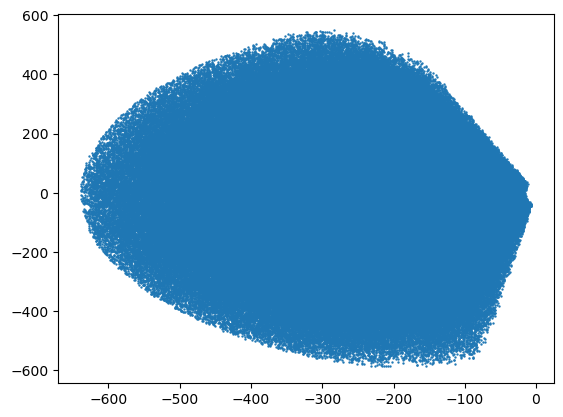

In [38]:
import matplotlib.pyplot as plt

plt.scatter(x2,y2,s=.5)
plt.show()

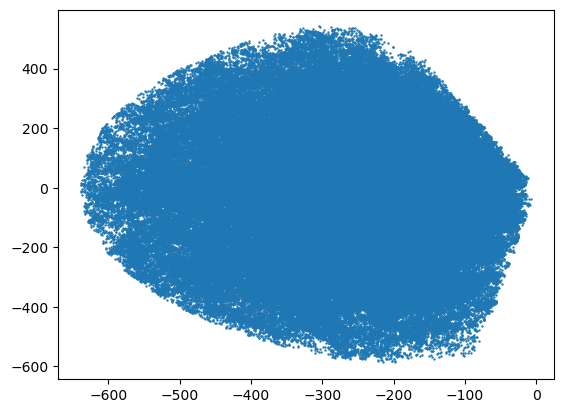

In [39]:
import matplotlib.pyplot as plt

plt.scatter(x1,y1,s=.5)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Load the TreeCorr output file
data = pd.read_csv("2dcorrelation.out", delim_whitespace=True, comment='#')

# Extract the relevant columns
sigma = data['sigma']
pi = data['pi']
xi = data['xi']
npairs = data['npairs']  # Number of pairs in each bin (for weighting)

# Compute xi_perp: Group by sigma and average over all pi bins
xi_perp = data.groupby('sigma').apply(
    lambda group: np.average(group['xi'], weights=group['npairs'])
).reset_index(name='xi_perp')

# Compute xi_parallel: Group by pi and average over all sigma bins
xi_parallel = data.groupby('pi').apply(
    lambda group: np.average(group['xi'], weights=group['npairs'])
).reset_index(name='xi_parallel')

# Save to files
xi_perp.to_csv("xi_perp.csv", index=False)
xi_parallel.to_csv("xi_parallel.csv", index=False)


/tmp/ipykernel_120532/1932557408.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("2dcorrelation.out", delim_whitespace=True, comment='#')


KeyError: 'sigma'